### Introduction

This EDA looks at crime incident reports in the city of Boston from June 2015 to September 2018. I use Folium for plotting an interactive heatmap of Boston, and seaborn for everything else.

The data is originally provided by Boston's open data hub, __[Analyze Boston](https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system)__. This kernel by  helped me get started with this dataset, and this other __[Kernel](https://www.kaggle.com/daveianhickey/how-to-folium-for-maps-heatmaps-time-analysis)__ by Dave Fisher-Hickey helped me get started with Folium.

In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import os
from wordcloud import WordCloud ,STOPWORDS, ImageColorGenerator
import seaborn as sns
%matplotlib inline
import folium
from folium.plugins import HeatMap
p = "YlGnBu"
p2 = "YlGn"
p3 = "Greys"
p4="viridis"
p5="coolwarm"

In [2]:
data=pd.read_csv('crime.csv', encoding='iso-8859-1')
data

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I182070945,619,Larceny,LARCENY ALL OTHERS,D14,808,NaN,2018-09-02 13:00:00,2018,9,Sunday,13,Part One,LINCOLN ST,42.357791,-71.139371,"(42.35779134, -71.13937053)"
1,I182070943,1402,Vandalism,VANDALISM,C11,347,NaN,2018-08-21 00:00:00,2018,8,Tuesday,0,Part Two,HECLA ST,42.306821,-71.060300,"(42.30682138, -71.06030035)"
2,I182070941,3410,Towed,TOWED MOTOR VEHICLE,D4,151,NaN,2018-09-03 19:27:00,2018,9,Monday,19,Part Three,CAZENOVE ST,42.346589,-71.072429,"(42.34658879, -71.07242943)"
3,I182070940,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,NaN,2018-09-03 21:16:00,2018,9,Monday,21,Part Three,NEWCOMB ST,42.334182,-71.078664,"(42.33418175, -71.07866441)"
4,I182070938,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,NaN,2018-09-03 21:05:00,2018,9,Monday,21,Part Three,DELHI ST,42.275365,-71.090361,"(42.27536542, -71.09036101)"
5,I182070936,3820,Motor Vehicle Accident Response,M/V ACCIDENT INVOLVING PEDESTRIAN - INJURY,C11,398,NaN,2018-09-03 21:09:00,2018,9,Monday,21,Part Three,TALBOT AVE,42.290196,-71.071590,"(42.29019621, -71.07159012)"
6,I182070933,724,Auto Theft,AUTO THEFT,B2,330,NaN,2018-09-03 21:25:00,2018,9,Monday,21,Part One,NORMANDY ST,42.306072,-71.082733,"(42.30607218, -71.08273260)"
7,I182070932,3301,Verbal Disputes,VERBAL DISPUTE,B2,584,NaN,2018-09-03 20:39:37,2018,9,Monday,20,Part Three,LAWN ST,42.327016,-71.105551,"(42.32701648, -71.10555088)"
8,I182070931,301,Robbery,ROBBERY - STREET,C6,177,NaN,2018-09-03 20:48:00,2018,9,Monday,20,Part One,MASSACHUSETTS AVE,42.331521,-71.070853,"(42.33152148, -71.07085307)"
9,I182070929,3301,Verbal Disputes,VERBAL DISPUTE,C11,364,NaN,2018-09-03 20:38:00,2018,9,Monday,20,Part Three,LESLIE ST,42.295147,-71.058608,"(42.29514664, -71.05860832)"


In [3]:
d2= pd.read_csv('offense_codes.csv', encoding='iso-8859-1')

__First, let's clean up and simplify this data set. I am going to focus on the two years with complete data (2016 and 2017). I will also narrow in on UCR Part One offenses, which include only the most serious crimes.__

In [4]:
# Keep only data from complete years (2016, 2017)
data = data.loc[data['YEAR'].isin([2016,2017])]
data=data[data["UCR_PART"]=='Part One']
data = data.drop(['INCIDENT_NUMBER','OFFENSE_CODE','UCR_PART','Location'], axis=1)
data['OCCURRED_ON_DATE'] = pd.to_datetime(data['OCCURRED_ON_DATE'])
data['SHOOTING'].fillna('N', inplace=True)
# Convert DAY_OF_WEEK to an ordered category
data['DAY_OF_WEEK'] = pd.Categorical(data.DAY_OF_WEEK, 
              categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
              ordered=True)

# Replace -1 values in Lat/Long with Nan
data.Lat.replace(-1, None, inplace=True)
data.Long.replace(-1, None, inplace=True)

# Rename columns to something easier to type (the all-caps are annoying!)
rename = {'OFFENSE_CODE_GROUP':'Group',
         'OFFENSE_DESCRIPTION':'Description',
         'DISTRICT':'District',
         'REPORTING_AREA':'Area',
         'SHOOTING':'Shooting',
         'OCCURRED_ON_DATE':'Date',
         'YEAR':'Year',
         'MONTH':'Month',
         'DAY_OF_WEEK':'Day',
         'HOUR':'Hour',
         'STREET':'Street'}
data.rename(index=str, columns=rename, inplace=True)

# Check
data['Group'].value_counts()

Larceny                       15709
Larceny From Motor Vehicle     6707
Aggravated Assault             4769
Residential Burglary           3309
Auto Theft                     2930
Robbery                        2882
Commercial Burglary             863
Other Burglary                  268
Homicide                        101
Name: Group, dtype: int64

In [5]:
data.dtypes
data.isnull().sum()
data.shape

(37538, 13)

# Types of serious crimes

Let's start by checking the frequency of different types of crimes. Since we have subsetted to only 'serious' crimes, there are only 9 different types of offenses - much more manageable than the 67 we started with.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text yticklabel objects>)

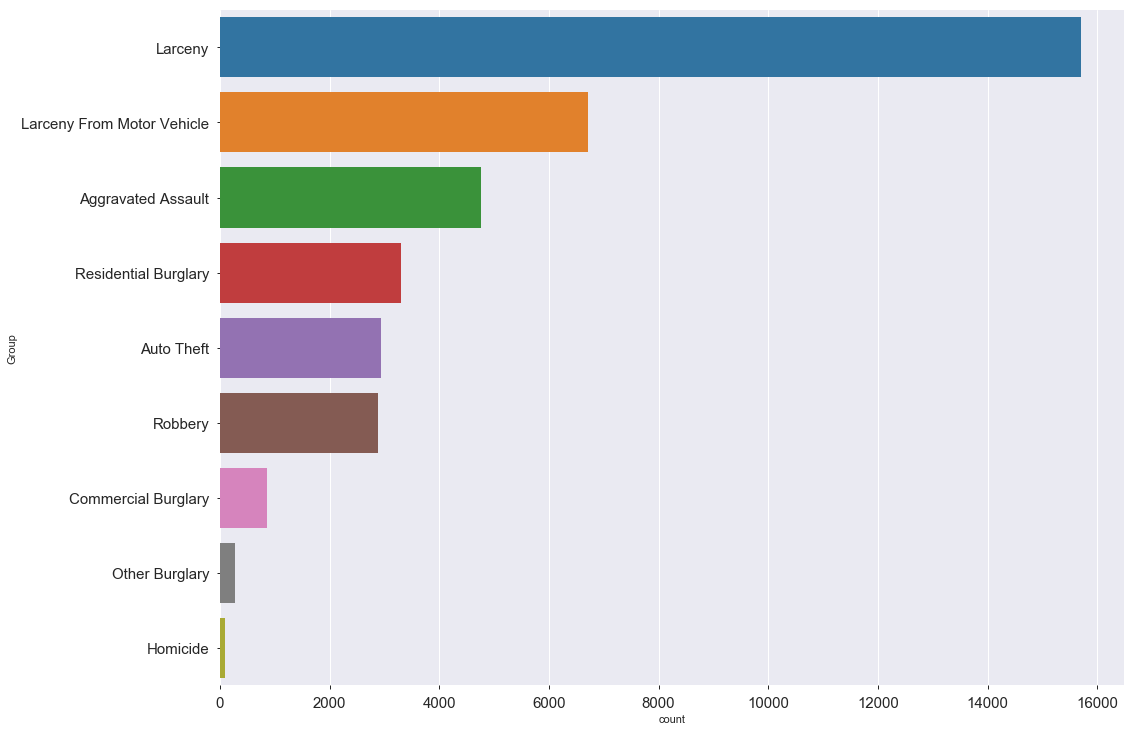

In [6]:
sns.catplot(y='Group', kind='count', height=10, aspect=1.5, order=data.Group.value_counts().index,  data=data)
plt.xticks(size=15)
plt.yticks(size=15)

*Larceny is by far the most common serious crime, and homicides are pretty rare.*

# When do serious crimes occur?

We can consider patterns across several different time scales: hours of the day, days of the week, and months of the year.

Text(-1.4500000000000028, 0.5, 'Count')

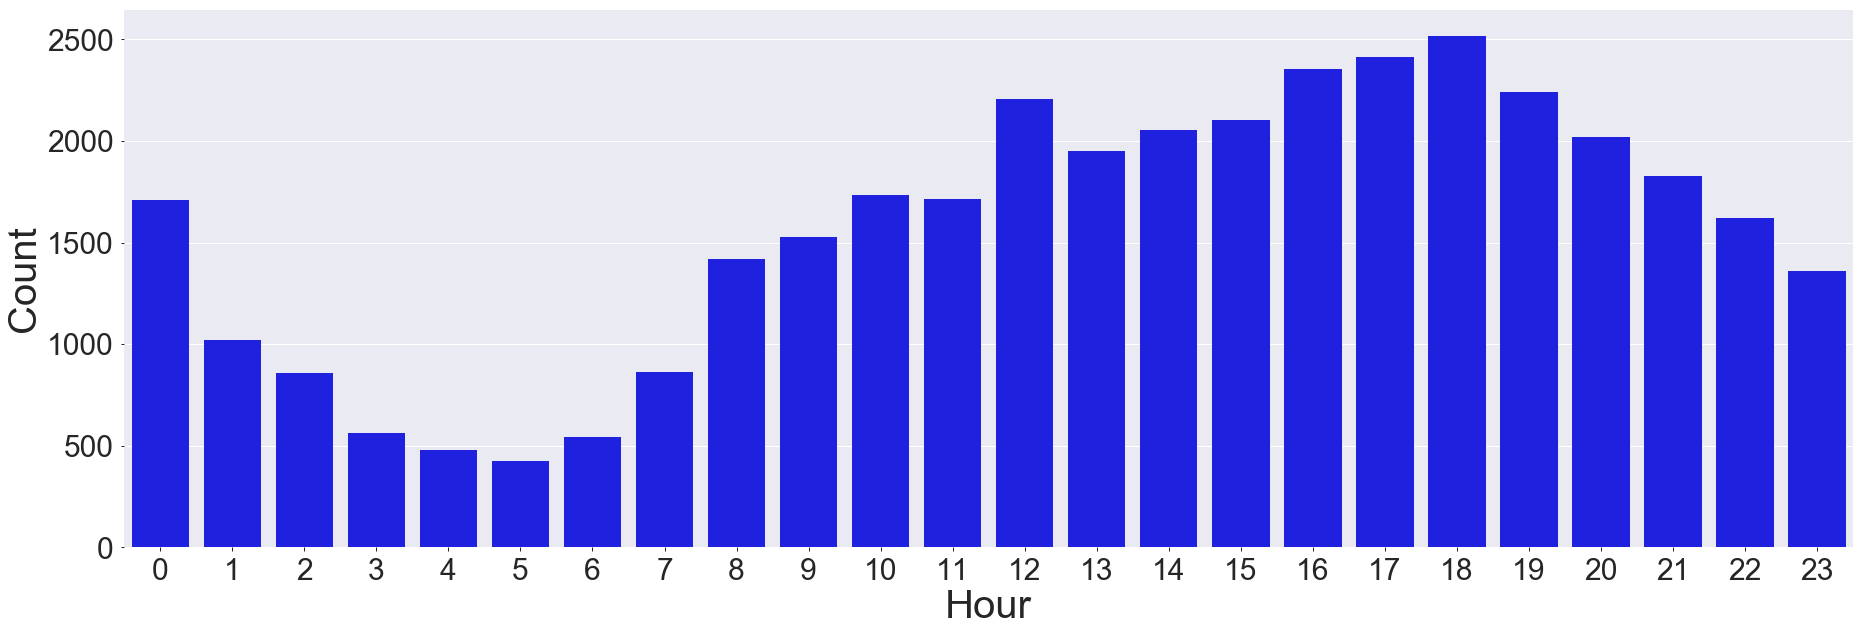

In [7]:
sns.catplot(x='Hour',
           kind='count',
            height=8.27, 
            aspect=3,
            color='blue',
           data=data)
plt.xticks(size=30)
plt.yticks(size=30)
plt.xlabel('Hour', fontsize=40)
plt.ylabel('Count', fontsize=40)

Text(-1.4499999999999744, 0.5, 'Count')

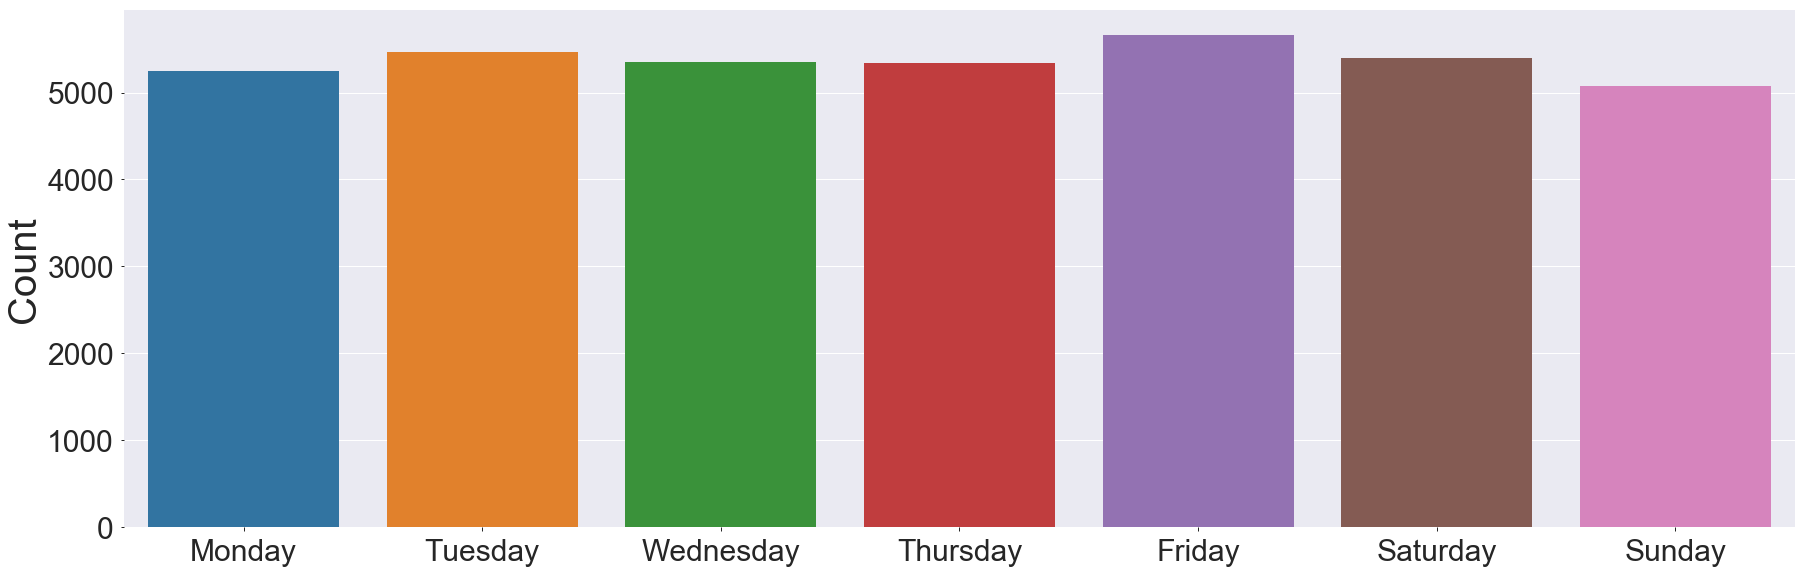

In [8]:
sns.catplot(x='Day',
           kind='count',
            height=8, 
            aspect=3,
           data=data)
plt.xticks(size=30)
plt.yticks(size=30)
plt.xlabel('')
plt.ylabel('Count', fontsize=40)

In [9]:
x=data.groupby('Group')['Day'].value_counts()
x= pd.DataFrame(x)

Text(-1.4500000000000028, 0.5, 'Count')

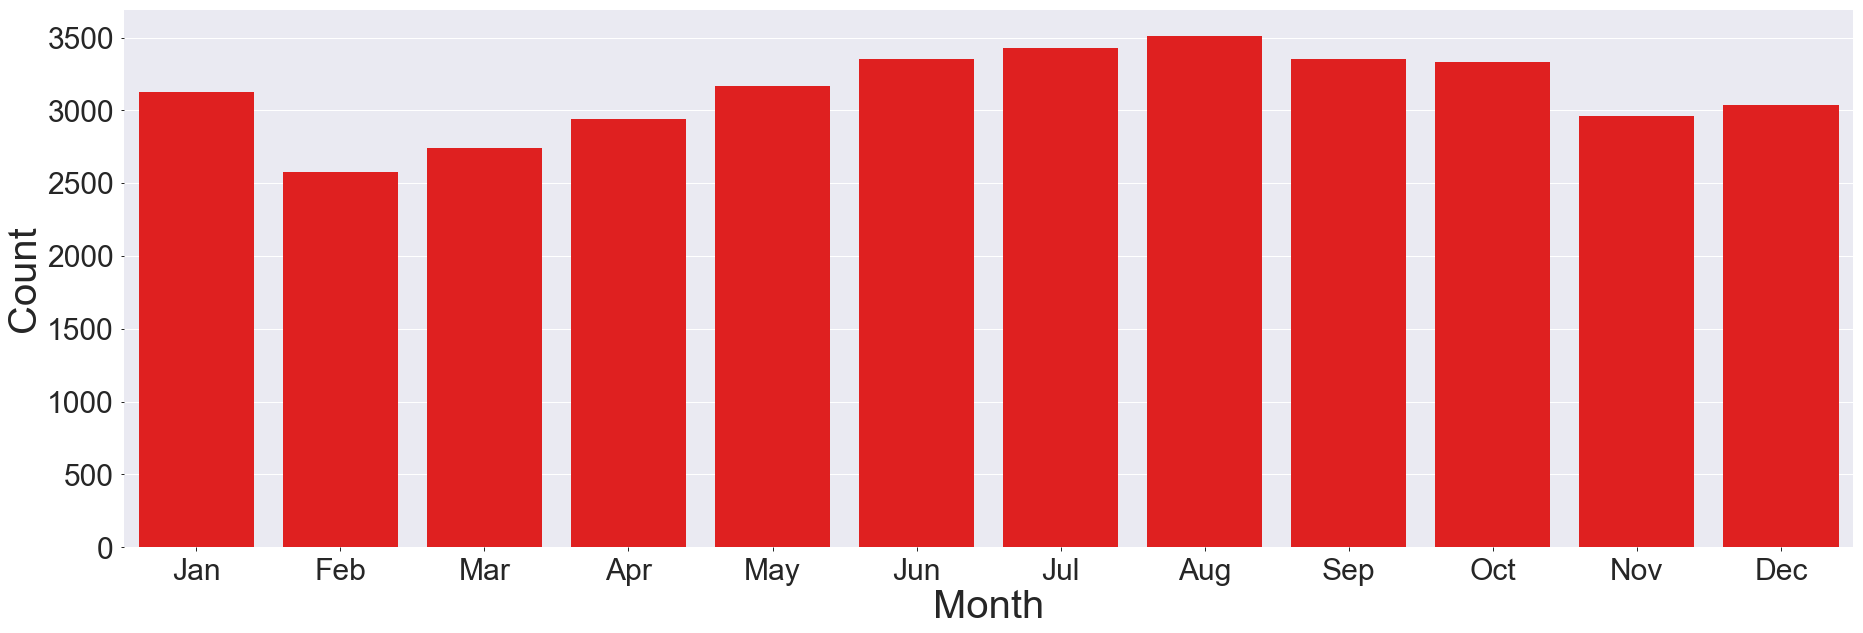

In [10]:
Months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

sns.catplot(x='Month',
           kind='count',
            height=8.27, 
            aspect=3,
            color='red',
           data=data)
plt.xticks(np.arange(12), Months, size=30)

# plt.xticks(size=30)
plt.yticks(size=30)
plt.xlabel('Month', fontsize=40)
plt.ylabel('Count', fontsize=40)

Crimes rates are low between 1-8 in the morning, and gradually rise throughout the day, peaking around 6 pm. There is some variation across days of the week, with Friday having the highest crime rate and Sunday having the lowest. The month also seems to have some influence, with the winter months of February-April having the lowest crime rates, and the summer/early fall months of June-October having the highest crime rates. There is also a spike in crime rates in the month of January. 

Are any other temporal factors associated with crime? [According to some crime experts](https://www.oxygen.com/homicide-for-the-holidays/blogs/its-the-most-dangerous-time-of-the-year-why-do-crimes-increase), several types of crime tend to increase around the holidays, particularly larsony and robbery. This can occur for many reasons: crowded shopping centers create more cover for thieves, travelers leave their homes vulnerable to burglary, and increased alcohol and drug use can raise the likelihood of conflict-related crime. Let's see if there is any evidence for this in our data, focusing in on the year 2017. I also added in a couple of days that are known to be especially rowdy in Boston, even though they aren't official holidays: St. Patrick's Day and the Boston Marathon.

In [11]:
# Create data for plotting
data['Day_of_year'] = data["Date"].dt.dayofyear
data_holidays = data[data.Year == 2017].groupby(['Day_of_year']).size().reset_index(name='counts')

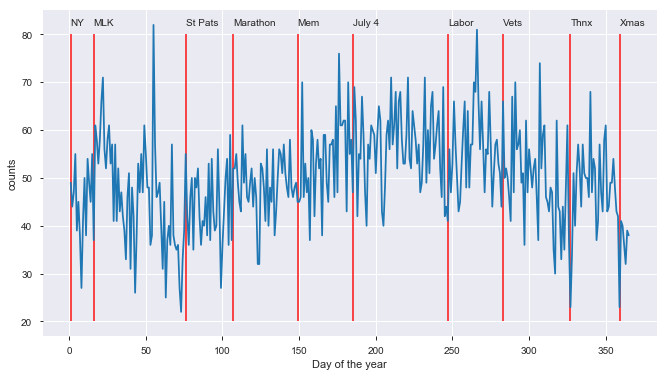

In [12]:
# Dates of major U.S. holidays in 2017
holidays = pd.Series(['2017-01-01', # New Years Day
                     '2017-01-16', # MLK Day
                     '2017-03-17', # St. Patrick's Day
                     '2017-04-17', # Boston marathon
                     '2017-05-29', # Memorial Day
                     '2017-07-04', # Independence Day
                     '2017-09-04', # Labor Day
                     '2017-10-10', # Veterans Day
                     '2017-11-23', # Thanksgiving
                     '2017-12-25']) # Christmas
holidays = pd.to_datetime(holidays).dt.dayofyear
holidays_names = ['NY',
                 'MLK',
                 'St Pats',
                 'Marathon',
                 'Mem',
                 'July 4',
                 'Labor',
                 'Vets',
                 'Thnx',
                 'Xmas']

import datetime as dt
# Plot crimes and holidays
fig, ax = plt.subplots(figsize=(11,6))
sns.lineplot(x='Day_of_year',
            y='counts',
            ax=ax,
            data=data_holidays)
plt.xlabel('Day of the year')
plt.vlines(holidays, 20, 80, alpha=0.8, color ='r')
for i in range(len(holidays)):
    plt.text(x=holidays[i], y=82, s=holidays_names[i])

Hm, I'm not seeing any clear signals here. In fact, many of these holidays appear to line up with especially low crime rates, particularly Thanksgiving and Christmas. Of course, this is data from just a single year, and detecting an association between a given holiday and crime rates would require a lot more data and a model that accounts for other factors. However, this does cause me to question the general idea that crime increases surrounding holidays - if that *is* true, it isn't super obvious from a birds-eye view of the data. Even the entire ["holiday season"](https://www.cpss.net/about/blog/2013/11/stay-safe-crime-rates-increase-during-holiday-season/) from Thanksgiving to Christmas doesn't seem to be especially elevated compared to the summer.  

# Where do serious crimes occur?

We can use the latitude and longitude columns to plot the location of crimes in Boston. By setting the alpha parameter to a very small value, we can see that there are some crime 'hotspots'. 

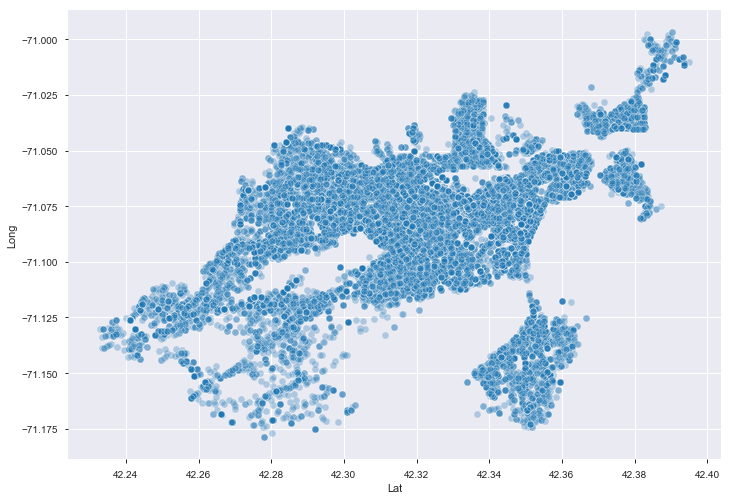

In [13]:
# Simple scatterplot
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.scatterplot(x='Lat',
               y='Long',
                alpha=0.3,
               data=data, ax=ax)

That looks like Boston alright. If you are at all familiar with Boston, you will not be too surprised to see that downtown Boston has the darkest points, but there are also some localities outside of the city center that have especially high crime rates. 

**Let's make another scatterplot, but this time we'll color points by district to see which districts have the highest crime rates.**

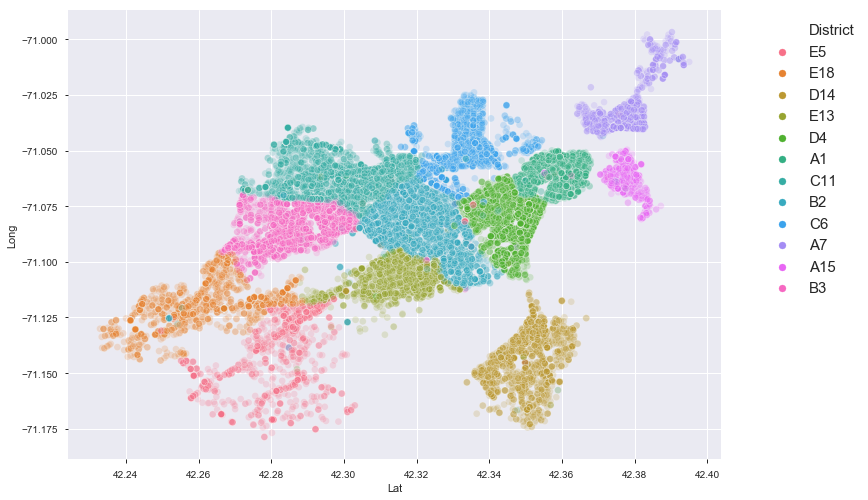

In [14]:
# Plot districts
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.scatterplot(x='Lat',
               y='Long',
                hue='District',
                alpha=0.2,
               data=data, ax=ax)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, fontsize=15)

We can now associate high crime rates with particular districts, most noteably A1 and D4, which correspond to the most crowded areas of downtown Boston. There is also a very high crime region visibe in district D14.

**Let's make things pretty by using Folium to make an interactive heatmap of Boston crimes. I will use the 2017 data only for this plot.**

In [15]:
# Create basic Folium crime map
crime_map = folium.Map(location=[42.3125,-71.0875], 
                       tiles = "Stamen Toner",
                      zoom_start = 11)

# Add data for heatmp 
data_heatmap = data[data.Year == 2017]
data_heatmap = data[['Lat','Long']]
data_heatmap = data.dropna(axis=0, subset=['Lat','Long'])
data_heatmap = [[row['Lat'],row['Long']] for index, row in data_heatmap.iterrows()]
HeatMap(data_heatmap, radius=10).add_to(crime_map)

# Plot!
crime_map

**ABOUT LARCENY**

Most of them around Newburry Street, Boylston Street, State Street and Downtown Crossing

In [16]:
import folium
from folium.plugins import HeatMap

map_hooray = folium.Map(location=[42.361145,-71.057083],
                    zoom_start = 12, min_zoom=12, tiles= "Stamen Toner" ) #Giving the location just write boston coordinat to google

heat_df = data[(data['Year']==2017 )& (data['Group']=='Larceny')]# I take 2017 cause there is more crime against to other years
# heat_df = data[data['Group']=='Larceny'] 
heat_df = heat_df[['Lat', 'Long']] #giving only latitude and longitude now in heat_df just latitude and longitude
                                        #from 2017 larceny responde
heat_df=heat_df.dropna()
folium.CircleMarker([42.356145,-71.064083],
                    radius=50,
                    popup='Homicide',
                    color='red',
                    ).add_to(map_hooray) #Adding mark on the map but it's hard to find correct place. 
                                         #it's take to muhc time
    
    
heat_data = [[row['Lat'],row['Long']] for index, row in heat_df.iterrows()]
#We have to give latitude and longitude like this [[lat, lon],[lat, lon],[lat, lon],[lat, lon],[lat, lon]]

HeatMap(heat_data, radius=10).add_to(map_hooray) #Adding map_hooray to HeatMap
map_hooray #Plotting

**ABOUT MOTOR VEHICLE ACCIDENT RESPONSE**

It's look everywhere is almost same accident it's mean thoese accident not cause of city road planning

Probably it's cause of human mistakes

In [17]:
map_hooray = folium.Map(location=[42.361145,-71.057083],
                    zoom_start = 12, min_zoom=12, tiles= "Stamen Toner" )

heat_df = data[(data['Year']==2017 )& (data['Group']=='Larceny From Motor Vehicle')]# I take 2017 cause there is more crime against to other years
heat_df = heat_df[['Lat', 'Long']]
heat_df = heat_df.dropna()

folium.CircleMarker([42.356145,-71.064083],
                    radius=50,
                    popup='Homicide',
                    color='red',
                    ).add_to(map_hooray) #Adding mark on the map but it's hard to find correct place. 
                                         #it's take to muhc time

heat_data = [[row['Lat'],row['Long']] for index, row in heat_df.iterrows()]
HeatMap(heat_data, radius=10).add_to(map_hooray)
map_hooray

**About Robbery**


In [18]:
map_hooray = folium.Map(location=[42.361145,-71.057083],
                    zoom_start = 12, min_zoom=12, tiles= "Stamen Toner" )

heat_df = data[(data['Year']==2017 )& (data['Group']=='Robbery')]# I take 2017 cause there is more crime against to other years
heat_df = heat_df[['Lat', 'Long']]
heat_df = heat_df.dropna()

folium.CircleMarker([42.356145,-71.064083],
                    radius=50,
                    popup='Homicide',
                    color='red',
                    ).add_to(map_hooray) #Adding mark on the map but it's hard to find correct place. 
                                         #it's take to muhc time

heat_data = [[row['Lat'],row['Long']] for index, row in heat_df.iterrows()]
HeatMap(heat_data, radius=10).add_to(map_hooray)
map_hooray

# Conclusions

In summary, this EDA shows:

* Larceny is by far the most common type of serious crime.
* Serious crimes are most likely to occur in the afternoon and evening.
* Serious crimes are most likely to occur on Friday and least likely to occur on Sunday.
* Serious crimes are most likely to occur in the summer and early fall, and least likely to occur in the winter (with the exeption of January, which has a crime rate more similar to the summer).
* There is no obvious connection between major holidays and crime rates.
* Serious crimes are most common in the city center, especially districts A1 and D4.

This EDA just scratches the surface of the dataset. Further analyses could explore how different types of crimes vary in time and space. I didn't even consider the less serious UCR Part Two and Part Three crimes, which are far more common than Part One crimes, but include interesting categories such as drug crimes. Another interesting direction would be to combine this with other data about Boston, such as demography or even the [weather](http://www.chicagotribune.com/news/data/ct-crime-heat-analysis-htmlstory.html), to investigate what factors predict crime rates across time and space.